In [2]:
"""
    The below code uses the "traditional" method to provide close fits that the model uses for standardization later
"""

import h5py
import numpy as np
import re
from tensorflow.keras.utils import Sequence

class HDF5Dataset(Sequence):
    def __init__(self, file_path, batch_size=1000):
        self.file_path = file_path
        self.batch_size = batch_size
        
        with h5py.File(file_path, 'r') as h5:
            data = []
            growth_numbers = []

            # Iterate through the groups and match the pattern
            for key in h5.keys():
                match = re.match(r'growth_(\d+)', key)
                if match:
                    growth_number = int(match.group(1))
                    growth_numbers.append(growth_number)

                    # Extract the corresponding dataset
                    dataset = np.array(h5[key]["spot_2"])
                    data.append(dataset)
                    
            # Concatenate all the datasets and normalize
            self.data = np.vstack(data)
            self.data = self.data.astype(np.float32)
            self.data_max = np.max(self.data)
            self.data /= self.data_max
       
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index * self.batch_size:(index + 1) * self.batch_size]
        return batch_data, np.full(len(batch_data), self.data_max)

# Specify the path to the HDF5 file
file_path = '/home/ferroelectric/sean/RHEED_4848_test6.h5'

# Create an instance of the HDF5Dataset generator
batch_size = 1000
data_generator = HDF5Dataset(file_path, batch_size=batch_size)


import numpy as np
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client
import h5py

# Defining the 2D Gaussian function
def gaussian2D(x_y, A, x0, y0, sigma_x, sigma_y):
    x, y = x_y
    return A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))


# Computing residuals for least-squares minimization
def residuals(params, x, y, data):
    A, x0, y0, sigma_x, sigma_y = params
    model = gaussian2D((x, y), A, x0, y0, sigma_x, sigma_y)
    return (model - data).ravel()

def convert_parameters(parameters):
    A, x0, y0, sigma_x, sigma_y = parameters
    
    mean_x = x0
    mean_y = y0
    cov_x = sigma_x
    cov_y = sigma_y
    
    # Calculate theta from the covariance values
    if cov_x != 0 and cov_y != 0:
        theta = 0.5 * np.arctan(2 * cov_x * cov_y / (cov_x**2 - cov_y**2)+1e-9)
    else:
        theta = 0.0
    
    return mean_x, mean_y, cov_x, cov_y, theta

# Fitting multiple images using Dask
def fit_and_convert_parameters(h5_filename):
    all_converted_params = []  
    all_images=[]
    
    with h5py.File(h5_filename, 'r') as h5_file:
        for group_num in range(1, 13):  
            group_name = f'growth_{group_num}'
            if group_name in h5_file:
                group = h5_file[group_name]['spot_2']

                images = group[:]  
                
                normalized_images = [image / image.max() for image in images]  
                all_images.extend(normalized_images)
                
                guesses = [add_guess(image) for image in normalized_images]
                fits = [fit_gaussian2D_delayed(image, guess) for image, guess in zip(normalized_images, guesses)]
                
                converted_params = [convert_parameters(params) for params in compute(*fits)]
                all_converted_params.extend(converted_params)  

    return all_converted_params, all_images


# Parallelizing the fit function using Dask's delayed
@delayed
def fit_gaussian2D_delayed(data, guess):
    y, x = np.indices(data.shape)
    result = least_squares(residuals, guess, args=(x, y, data))
    return result.x

# Adding an initial guess for the fit
def add_guess(data):
    A_guess = np.max(data)
    x0_guess, y0_guess = np.unravel_index(np.argmax(data), data.shape)
    sigma_x_guess = sigma_y_guess = np.std(data)
    return [A_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess]

# Main code
if __name__ == "__main__":
    h5_filename = "/home/ferroelectric/sean/RHEED_4848_test6.h5"  # Replace with the actual path
    
    with Client() as client:  # Starts a local cluster or connects to an existing one
        results ,images2= fit_and_convert_parameters(h5_filename)


"""This is the standard scaler being fit on the traditional data."""
from sklearn.preprocessing import StandardScaler
output_scaler = StandardScaler()
data=results #structed like [[meanx1,meany1,covx1,covy1,theta1],[meanx2,meany2,covx2,covy2,theta2]]
output_scaler.fit(data)

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
import math

class LeNet5(tf.keras.Model):
    def __init__(self, func, num_classes, testing=False):
        super(LeNet5, self).__init__()
        self.func = func
        self.testing = testing
        
        self.layer1 = tf.keras.Sequential([
            Conv2D(6, kernel_size=5, strides=1, padding='valid', input_shape=(48, 48, 1)),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D(pool_size=4, strides=4)
        ])
        
        self.layer2 = tf.keras.Sequential([
            Conv2D(16, kernel_size=5, strides=1, padding='valid'),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D(pool_size=2, strides=2)
        ])
        
        self.flatten = Flatten()
        
        self.fc = Dense(98)
        self.relu = ReLU()
        self.fc1 = Dense(52)
        self.relu1 = ReLU()
        self.fc2 = Dense(num_classes)

    def call(self, x):
        x = tf.cast(x, tf.float32)
        out = self.layer1(x)
        out = self.layer2(out)

        out = self.flatten(out)
        
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        embedding = self.fc2(out)
        
        # Assume output_scaler is defined and accessible
        output_scaler = ...  # Define or load your scaler here
        
        unscaled_param = embedding * tf.sqrt(output_scaler.var_) + output_scaler.mean_
        unscaled_param = tf.Variable(unscaled_param)
        unscaled_param[:, 4].assign((math.pi / 4) * (tf.nn.tanh(unscaled_param[:, 4]) + 1))
        
        final = self.func(unscaled_param)
        
        if self.testing:
            return embedding, unscaled_param, final 
        
        return final

import tensorflow as tf
from tensorflow.keras import layers, models

class LeNet5_inference(tf.keras.Model):
    def __init__(self, num_classes):
        super(LeNet5_inference, self).__init__()
        self.layer1 = models.Sequential([
            layers.Conv2D(6, kernel_size=5, strides=1, padding='valid', input_shape=(32, 32, 1)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=4, strides=4)
        ])
        self.layer2 = models.Sequential([
            layers.Conv2D(16, kernel_size=5, strides=1, padding='valid'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=2, strides=2)
        ])
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(98)
        self.relu = layers.ReLU()
        self.fc1 = layers.Dense(52)
        self.relu1 = layers.ReLU()
        self.fc2 = layers.Dense(num_classes)
        
        self.output_scaler_var = tf.Variable([1.0], trainable=False)  # Placeholder for the variance
        self.output_scaler_mean = tf.Variable([0.0], trainable=False)  # Placeholder for the mean

    def call(self, x):
        x = tf.cast(x, tf.float32)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        embedding = self.fc2(out)
        embedding = embedding * tf.sqrt(self.output_scaler_var) + self.output_scaler_mean  # Unscaling
        
        return embedding

    
import tensorflow as tf
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt
import numpy as np

class GaussianGenerator(Layer):
    def __init__(self, img_dim):
        super(GaussianGenerator, self).__init__()
        self.img_dim = img_dim

    def call(self, params):
        batch_size = tf.shape(params)[0]
        mean_x, mean_y, cov_x, cov_y, theta = tf.unstack(params, axis=-1)
        cov_x = tf.clip_by_value(cov_x, clip_value_min=1e-9, clip_value_max=tf.float32.max)
        cov_y = tf.clip_by_value(cov_y, clip_value_min=1e-9, clip_value_max=tf.float32.max)

        x = tf.range(self.img_dim[1], dtype=tf.float32)
        y = tf.range(self.img_dim[0], dtype=tf.float32)
        x = tf.reshape(x, (-1, 1))
        x = tf.tile(x, (1, self.img_dim[0]))
        y = tf.reshape(y, (1, -1))
        y = tf.tile(y, (self.img_dim[1], 1))
        x = tf.tile(tf.expand_dims(x, 0), [batch_size, 1, 1])
        y = tf.tile(tf.expand_dims(y, 0), [batch_size, 1, 1])
        
        rota_matrix = tf.stack([tf.cos(theta), -tf.sin(theta), tf.sin(theta), tf.cos(theta)], axis=-1)
        rota_matrix = tf.reshape(rota_matrix, (batch_size, 2, 2))

        xy = tf.stack([x - tf.reshape(mean_x, (-1, 1, 1)), y - tf.reshape(mean_y, (-1, 1, 1))], axis=-1)
        xy = tf.einsum('bijk,bkl->bijl', xy, rota_matrix)

        img = tf.exp(-0.5 * (tf.square(xy[:, :, :, 0]) / tf.square(tf.reshape(cov_x, (-1, 1, 1))) + tf.square(xy[:, :, :, 1]) / tf.square(tf.reshape(cov_y, (-1, 1, 1)))))

        return tf.expand_dims(img, axis=1)

# Example usage
img_dim = (48, 48)  # Replace with the desired image dimensions
model = GaussianGenerator(img_dim)
sample_params = tf.constant([[19.2763, 24.8520, 11.2061, 6.8914, 0.7006]], dtype=tf.float32)

# Call the model to generate the Gaussian image
generated_img = model(sample_params)

# Display the generated image shape
print("Generated Image Shape:", generated_img.shape)
plt.imshow(generated_img.numpy().squeeze(0).squeeze(0), cmap='gray')
plt.show()


import tensorflow as tf

def custom_weighted_mse_loss(I, J, n):
    """
    Compute the custom weighted MSE loss between two grayscale images I and J.

    Parameters:
    - I: tf.Tensor of shape [batch_size, 1, M, N], the input image
    - J: tf.Tensor of shape [batch_size, 1, M, N], the target image
    - n: int, the exponent to raise the input image for the weight

    Returns:
    - loss: tf.Tensor, the computed loss
    """
    # Compute the weight
    W = tf.pow(I, n)

    # Compute the squared differences
    squared_diffs = tf.pow(I - J, 2)

    # Compute the weighted squared differences
    weighted_squared_diffs = W * squared_diffs

    # Compute the loss
    loss = tf.reduce_mean(weighted_squared_diffs)

    return loss

# Test the function
I = tf.random.normal((16, 1, 128, 128))  # Batch of 16 128x128 grayscale images
J = tf.random.normal((16, 1, 128, 128))  # Batch of 16 128x128 grayscale images
n = 2  # Exponent value

loss = custom_weighted_mse_loss(I, J, n)
print("Custom Weighted MSE Loss:", loss.numpy())


import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
from tqdm import tqdm

# Assume `LeNet5Keras` and `GaussianGenerator` are already defined and imported

# Initialize the models
generator = GaussianGenerator(img_dim=(48, 48))
net = LeNet5(generator, num_classes=5)
# net = net.get_model()

# Define the custom loss function
def custom_weighted_mse_loss(I, J, n):
    W = tf.pow(I, n)
    squared_diffs = tf.pow(I - J, 2)
    weighted_squared_diffs = W * squared_diffs
    loss = tf.reduce_mean(weighted_squared_diffs)
    return loss

# Optimizer and learning rate scheduler
initial_lr = 1e-6
optimizer = Adam(learning_rate=initial_lr)

# OneCycleLR is not directly available in Keras, using a custom scheduler instead
def scheduler(epoch, lr):
    if epoch < num_epochs / 2:
        return lr * (1 + epoch / (num_epochs / 2)) * (1e-3 / initial_lr)
    else:
        return lr * (1 - (epoch - num_epochs / 2) / (num_epochs / 2)) * (initial_lr / 1e-3)

lr_scheduler = LearningRateScheduler(scheduler)

# Training parameters
num_epochs = 200
n = 1
batch_size = 32


# Training loop
best_loss = float('inf')

for epoch in range(num_epochs):
    running_loss = 0.0
    
    if epoch % 10 == 0:
        n += 0.1

    for images, image_max in tqdm(data_loader):
        
        images = tf.expand_dims(images, axis=-1)
        with tf.GradientTape() as tape:
            scaled, unscaled, outputs = net(images, training=True)
            loss = custom_weighted_mse_loss(images, outputs, n)
        
        gradients = tape.gradient(loss, net.trainable_variables)
        tf.clip_by_norm(gradients, 1.0)
        optimizer.apply_gradients(zip(gradients, net.trainable_variables))
        
        running_loss += loss.numpy()
        
    average_loss = running_loss / len(data_loader)
    lr_scheduler.on_epoch_end(epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

    # Save the model if the loss improves
    if average_loss < best_loss:
        best_loss = average_loss
        net.save('best_model.h5')

# Load the best model for inference
best_model = tf.keras.models.load_model('best_model.h5', custom_objects={'custom_weighted_mse_loss': custom_weighted_mse_loss})


/home/ferroelectric/micromamba/envs/HLS_new/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35161 instead
  warnings.warn(
/home/ferroelectric/micromamba/envs/HLS_new/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 234.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/ferroelectric/micromamba/envs/HLS_new/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 229.09 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/ferroelectric/micromamba/envs/HLS_new/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 202.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using fu

StandardScaler()

2024-05-21 18:02:35.257476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 18:02:35.821650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Generated Image Shape: (1, 1, 48, 48)


2024-05-21 18:02:38.870193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 18:02:38.870493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 18:02:38.887907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

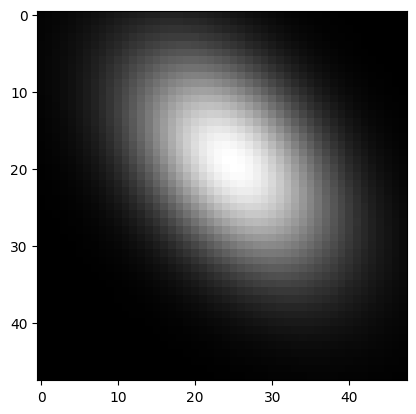

Custom Weighted MSE Loss: 3.994163


0it [00:00, ?it/s]

TypeError: 'ellipsis' object is not iterable